In [1]:
import pandas as pd
import numpy as np

In [2]:
fill_df = pd.read_csv("fullMnist.csv", index_col=0)

In [106]:
class TimsLDAClassifier:

    def __init__(self, df: pd.DataFrame):
        # td is training data
        self.td = df
        self.classes = np.sort(self.td.label.unique()).tolist()
        self.num_samples, self.sample_size = self.td.shape
        # subtract 1 from sample size to not count label
        self.sample_size -= 1

    def sortDataByClass(self):
        self.td = self.td.sort_values(by=['label'])

    def buildClassMeans(self):        
        # Allocate array with the correct size - (sample_size) x classes
        self.means = np.zeros(shape=(len(self.classes), self.sample_size)) 
        for clazz in self.classes:
            self.means[self.classes.index(clazz)] = self.meanForClass(clazz)
        
    def meanForClass(self, clazz):
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        classSubset = np.sum(classSubset, axis=0) / classSubset.shape[0]
        return classSubset

    def withinClassCovarianceForClass(self, clazz):
        temp = np.zeros(shape=(self.sample_size, self.sample_size))
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        print("Within class covariance for class: " + str(clazz) + " " + str(classSubset.shape))
        for row in classSubset:
            curRow = np.subtract(row, self.means[self.classes.index(clazz)])
            print("After subtract " + str(curRow.shape) + " " + str(np.sum(curRow)))
            curRow = np.outer(np.transpose(curRow), curRow)
            print("After mult " + str(np.trace(curRow)))
            temp += curRow
        return temp
        
    def withinClassCovariance(self):
        swCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        for clazz in self.classes:
            swCovariance += self.withinClassCovarianceForClass(clazz)
        self.sw = swCovariance

    def betweenClassCovariance(self):
        sbCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        globalMean = np.sum(self.means, axis=0)
        for clazz in self.classes:
            temp = np.subtract(self.means[self.classes.index(clazz)], globalMean)
            temp = np.outer(np.transpose(temp), temp)
            # Scale by the number of samples of this class
            temp = temp * self.td[self.td['label'] == clazz].shape[0]
            sbCovariance += temp
        self.sb = sbCovariance

    def getSortedEigens(self):
        weightMatrix = np.matmul(np.linalg.pinv(self.sw), self.sb)
        eigenValues, self.eigenVectors = np.linalg.eig(weightMatrix)
        # Transpose the eigenVectors because of the way it returns and the way I am indexing it
        self.eigenVectors = np.transpose(self.eigenVectors)        
        # Add index for each eigenvalue so that it can be correllated to its eigenvector after a sort
        eigenValues = np.c_[eigenValues, range(0, eigenValues.shape[0])]
        # Sort the eigenValues largest first
        self.sortedEigenValues = np.flip(eigenValues[eigenValues[:,0].argsort()], axis=0)

    def createMapToLowerDimensionality(self, lowerDimension: int):
        self.w = np.zeros(shape=(lowerDimension, self.sample_size), dtype=np.complex128)
        for i in range(0, lowerDimension):
            self.w[i] = self.eigenVectors[int(self.sortedEigenValues[i][1].real)]
        self.w = np.transpose(self.w)

    def projectDataToLowerDimension(self):
        self.projectedData = np.matmul(self.td.drop(columns='label').to_numpy(), self.w)
        

In [69]:
np.set_printoptions(threshold=10000)
print(testClassifier.sortedEigenValues)

[[ 8.45541885e+03+0.00000000e+00j  5.60000000e+01+0.00000000e+00j]
 [ 1.99969576e+01+0.00000000e+00j  5.70000000e+01+0.00000000e+00j]
 [ 1.65130375e+01+0.00000000e+00j  5.80000000e+01+0.00000000e+00j]
 [ 1.17950559e+01+0.00000000e+00j  5.90000000e+01+0.00000000e+00j]
 [ 9.75245927e+00+0.00000000e+00j  6.00000000e+01+0.00000000e+00j]
 [ 6.68336553e+00+0.00000000e+00j  6.10000000e+01+0.00000000e+00j]
 [ 6.25806091e+00+0.00000000e+00j  6.20000000e+01+0.00000000e+00j]
 [ 4.18924219e+00+0.00000000e+00j  6.30000000e+01+0.00000000e+00j]
 [ 3.64795288e+00+0.00000000e+00j  6.40000000e+01+0.00000000e+00j]
 [ 2.98175979e+00+0.00000000e+00j  6.50000000e+01+0.00000000e+00j]
 [ 3.66087310e-12+0.00000000e+00j  6.80000000e+01+0.00000000e+00j]
 [ 3.30395735e-12+0.00000000e+00j  7.30000000e+01+0.00000000e+00j]
 [ 3.11461431e-12+1.00915546e-12j  7.40000000e+01+0.00000000e+00j]
 [ 3.11461431e-12-1.00915546e-12j  7.50000000e+01+0.00000000e+00j]
 [ 2.80631657e-12+5.90744192e-13j  8.30000000e+01+0.00000000e+

In [78]:
#print(np.sum(testClassifier.eigenVectors[:][56]))
print(np.where(testClassifier.eigenVectors[:][56] == 1))
print(testClassifier.eigenVectors[56][640])

(array([640], dtype=int64),)
(1+0j)


In [82]:
testdims = np.random.rand(5,5)


[[0.70636129 0.846813   0.37238412 0.07449525 0.56550993]
 [0.4417457  0.46107726 0.79472061 0.76757929 0.72767441]
 [0.63234357 0.03307028 0.26259754 0.40340285 0.2765305 ]
 [0.54704402 0.89127099 0.50721211 0.21804609 0.25316508]
 [0.60828071 0.66697728 0.4279817  0.86179772 0.77801208]]
[0.70636129 0.846813   0.37238412 0.07449525 0.56550993]


In [85]:
print(testdims)
print(testdims[:][3])

[[0.70636129 0.846813   0.37238412 0.07449525 0.56550993]
 [0.4417457  0.46107726 0.79472061 0.76757929 0.72767441]
 [0.63234357 0.03307028 0.26259754 0.40340285 0.2765305 ]
 [0.54704402 0.89127099 0.50721211 0.21804609 0.25316508]
 [0.60828071 0.66697728 0.4279817  0.86179772 0.77801208]]
[0.54704402 0.89127099 0.50721211 0.21804609 0.25316508]


In [95]:
testmatrix = np.matmul(np.linalg.pinv(testClassifier.sw), testClassifier.sb)
matrixByVector = np.matmul(testmatrix, testClassifier.eigenVectors[56])
scalarByVector = (testClassifier.sortedEigenValues[0][0] * testClassifier.eigenVectors[56])
print(matrixByVector.shape)
print(scalarByVector.shape)
print(matrixByVector - scalarByVector)

(784,)
(784,)
[    0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j
     0.        +0.j     0.        +0.j     0.        +0.j


In [102]:
weightMatrix = np.matmul(np.linalg.pinv(testClassifier.sw), testClassifier.sb)
eigenValues, eigenVectors = np.linalg.eig(weightMatrix)


In [105]:
eigenVectorsT = np.transpose(eigenVectors)
matrixByVector = np.matmul(weightMatrix, eigenVectorsT[0])
scalarByVector = (eigenValues[0] * eigenVectorsT[0])
print(matrixByVector.shape)
print(scalarByVector.shape)
result = matrixByVector - scalarByVector
print(np.sum(result))

(784,)
(784,)
0j


In [9]:
tinySample = fill_df.head(200)

In [107]:
testClassifier = TimsLDAClassifier(tinySample)
print(testClassifier.num_samples)
print(testClassifier.sample_size)
testClassifier.buildClassMeans()
testClassifier.withinClassCovariance()
testClassifier.betweenClassCovariance()
testClassifier.getSortedEigens()
testClassifier.createMapToLowerDimensionality(2)
testClassifier.projectDataToLowerDimension()

200
784
Within class covariance for class: 0 (21, 784)
After subtract (784,) -5256.047619047618
After mult 1605654.3786848073
After subtract (784,) -918.047619047619
After mult 2064967.1405895692
After subtract (784,) 155.9523809523812
After mult 3301941.997732426
After subtract (784,) 914.9523809523812
After mult 2365984.0453514736
After subtract (784,) 9191.952380952382
After mult 2855321.235827664
After subtract (784,) 5540.952380952382
After mult 3354205.4739229023
After subtract (784,) 9893.952380952382
After mult 3240552.664399093
After subtract (784,) -11639.047619047618
After mult 5258139.283446712
After subtract (784,) 5921.952380952382
After mult 2675471.997732426
After subtract (784,) -2316.047619047619
After mult 2027133.902494331
After subtract (784,) 600.952380952381
After mult 2045717.8548752833
After subtract (784,) -2477.0476190476193
After mult 3171415.950113379
After subtract (784,) 1371.9523809523812
After mult 1873180.664399093
After subtract (784,) -7453.047619047

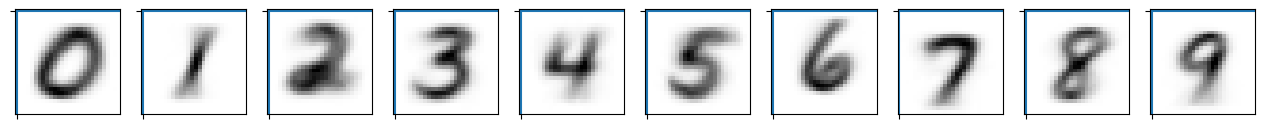

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
for i in range(0, sample_size):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(testClassifier.means[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

C:\Users\timmy\OneDrive\GradSchool\MachineLearning\mnistExample\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


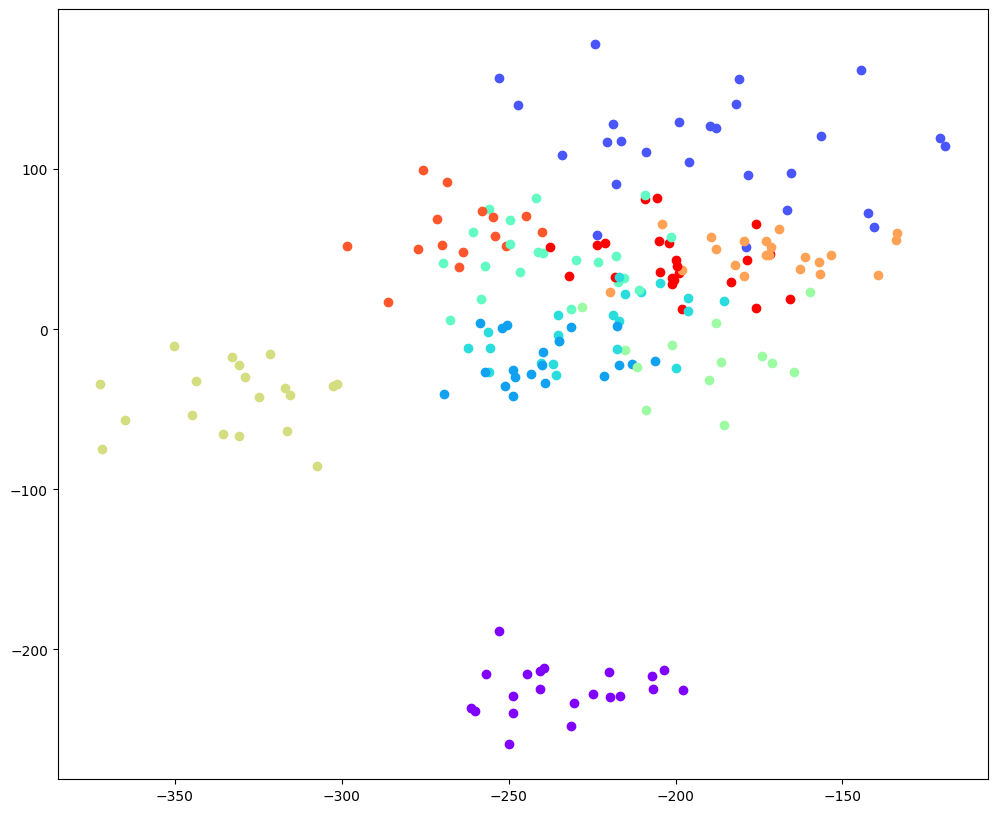

In [108]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(testClassifier.classes)))
plotlabels = {testClassifier.classes[c] : colors[c] for c in range(len(testClassifier.classes))}

plt.figure(figsize=(12,10))
for i, point in enumerate(testClassifier.projectedData):
    plt.scatter(point[0], point[1], color=plotlabels[testClassifier.td.iloc[i].label])

plt.show()

In [9]:
np.set_printoptions(threshold=10000)
print(testClassifier.w.imag)

[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-5.23017097e-03  3.76871818e-01]
 [ 5.23017097e-03 -3.76871818e-01]
 [-1.99865565e-02  2.12021232e-02]
 [ 1.99865565e-02 -2.12021232e-02]
 [-1.26000898e-02  7.75298016e-02]
 [ 1.26000898e-02 -7.75298016e-02]
 [-1.40547136e-02 -1.07028404e-01]
 [ 1.40547136e-02  1.07028404e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-2.81313031e-02 -1.72828685e-01]
 [ 2.81313031e-02  1.72828685e-01]
 [-1.86619955e-02  1.12190725e-02]
 [ 1.86619955e-02 -1.12190725e-02]
 [-5.52268882e-02 -2.69239261e-02]
 [ 5.52268882e-02  2.69239261e-02]
 [ 7.64912254e-03 -2.16405111e-02]
 [-7.64912254e-03  2.16405111e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 6.71485972e-02  7.38412797e-02]
 [-6.71485972e-02 -7.38412797e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.36817789e-02 -2